In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [185]:
data = pd.read_csv("to-modal.csv")

# Преобразуем колонку 'dt' в DatetimeIndex
data['dt'] = pd.to_datetime(data['dt'])
data = data.set_index('dt')  # Устанавливаем 'dt' как индекс

# Удаляем колонку 'dt', если она не нужна (так как есть год, месяц, квартал)
data = data.drop('dt', axis=1, errors='ignore')

targeted = data['Price'].dropna()

In [186]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['quarter'] = data.index.quarter

for lag in [1, 2, 3, 6, 12]:
    data[f'lag_{lag}'] = data['Price'].shift(lag)
    
# Выбор признаков и целевой переменной
features = ['year', 'month', 'day', 'quarter', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12']
target = 'Price'

In [187]:
train_size = int(len(data) * 0.8)  # 80% тренировочных данных
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

X_train = train_data.drop('Price', axis=1)
y_train = train_data['Price']
X_test = test_data.drop('Price', axis=1)
y_test = test_data['Price']

In [188]:
# Создание модели
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=2,
    reg_alpha=0.5,
    reg_lambda=1.0
)

# Обучение
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=1
)

# Метрики для кросс-валидации
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error),
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
}

# Кросс-валидация (например, 5 фолдов)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Предсказание и оценка
y_pred = model.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R² на каждом фолде: {scores}")
print(f"Средний R²: {scores.mean():.4f}")

[0]	validation_0-rmse:0.19489
[1]	validation_0-rmse:0.19254
[2]	validation_0-rmse:0.19029
[3]	validation_0-rmse:0.18814
[4]	validation_0-rmse:0.18609
[5]	validation_0-rmse:0.18420
[6]	validation_0-rmse:0.18239
[7]	validation_0-rmse:0.18059
[8]	validation_0-rmse:0.17895
[9]	validation_0-rmse:0.17733
[10]	validation_0-rmse:0.17583
[11]	validation_0-rmse:0.17440
[12]	validation_0-rmse:0.17300
[13]	validation_0-rmse:0.17215
[14]	validation_0-rmse:0.17120
[15]	validation_0-rmse:0.16979
[16]	validation_0-rmse:0.16844
[17]	validation_0-rmse:0.16769
[18]	validation_0-rmse:0.16667
[19]	validation_0-rmse:0.16549
[20]	validation_0-rmse:0.16458
[21]	validation_0-rmse:0.16350
[22]	validation_0-rmse:0.16295
[23]	validation_0-rmse:0.16195
[24]	validation_0-rmse:0.16101
[25]	validation_0-rmse:0.16064
[26]	validation_0-rmse:0.15978
[27]	validation_0-rmse:0.15912
[28]	validation_0-rmse:0.15832
[29]	validation_0-rmse:0.15758
[30]	validation_0-rmse:0.15717
[31]	validation_0-rmse:0.15680
[32]	validation_0-

[155]	validation_0-rmse:0.15027
[156]	validation_0-rmse:0.15006
[157]	validation_0-rmse:0.14999
[158]	validation_0-rmse:0.15001
[159]	validation_0-rmse:0.15007
[160]	validation_0-rmse:0.15007
[161]	validation_0-rmse:0.15032
[162]	validation_0-rmse:0.15012
[163]	validation_0-rmse:0.15010
[164]	validation_0-rmse:0.15007
[165]	validation_0-rmse:0.15012
[166]	validation_0-rmse:0.15009
[167]	validation_0-rmse:0.15016
[168]	validation_0-rmse:0.14997
[169]	validation_0-rmse:0.14997
[170]	validation_0-rmse:0.14989
[171]	validation_0-rmse:0.14994
[172]	validation_0-rmse:0.14976
[173]	validation_0-rmse:0.14976
[174]	validation_0-rmse:0.14968
[175]	validation_0-rmse:0.14950
[176]	validation_0-rmse:0.14950
[177]	validation_0-rmse:0.14950
[178]	validation_0-rmse:0.14942
[179]	validation_0-rmse:0.14948
[180]	validation_0-rmse:0.14932
[181]	validation_0-rmse:0.14932
[182]	validation_0-rmse:0.14924
[183]	validation_0-rmse:0.14922
[184]	validation_0-rmse:0.14924
[185]	validation_0-rmse:0.14908
[186]	va

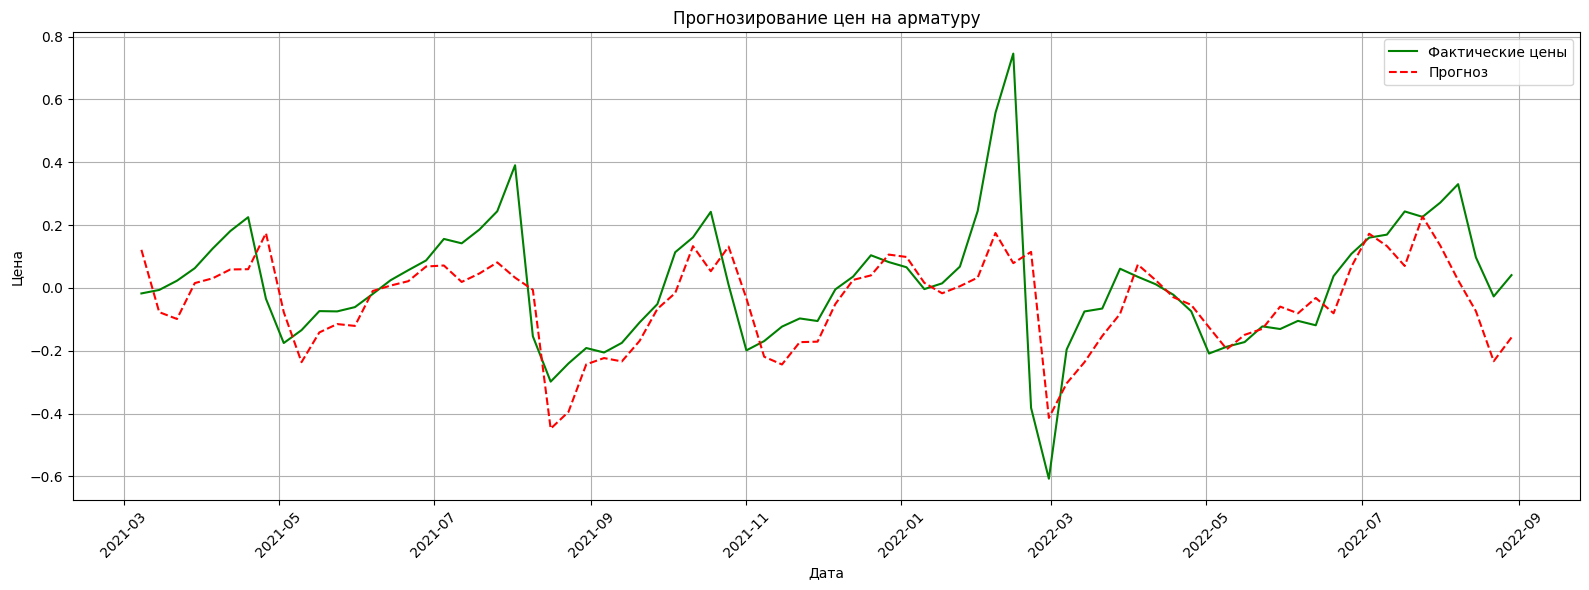

In [189]:
# Визуализация
plt.figure(figsize=(16, 6))
plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
plt.plot(X_test.index, y_pred, label='Прогноз', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

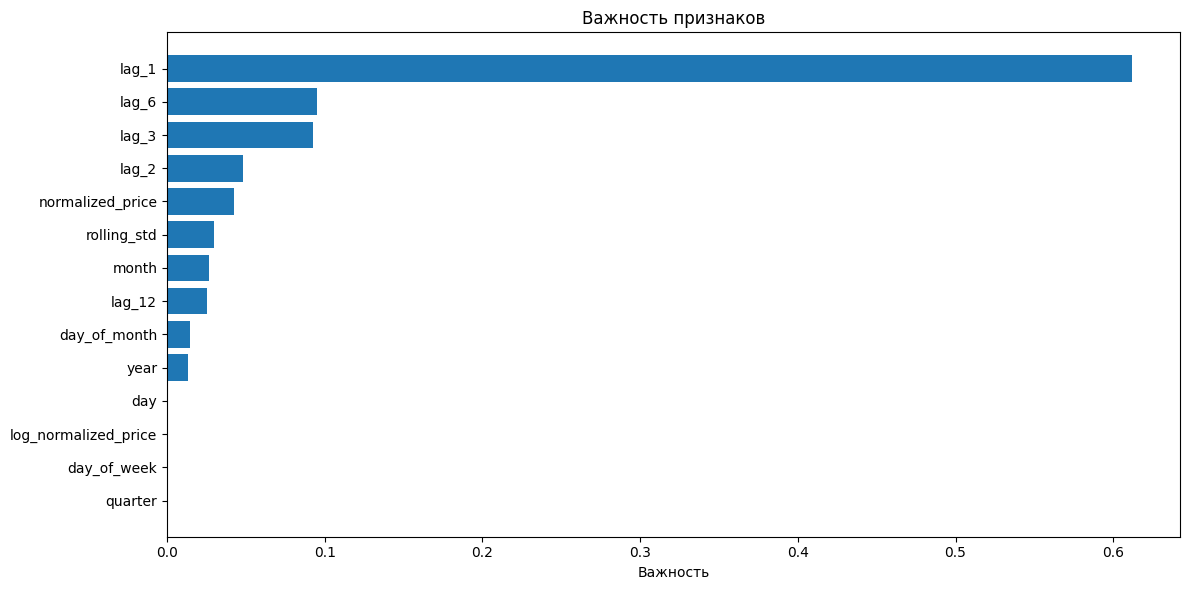

In [190]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

features = X_train.columns  # Если X_train — это DataFrame

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

In [191]:
# Сохранение в JSON-формате
model.save_model("xgboost_model.json")